In [111]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt


In [112]:
from tensorflow.python.client import device_lib
tf.config.list_physical_devices("GPU")

[]

In [113]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15110263906459005111,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16137477533039892209
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 11709117822057031536
 physical_device_desc: "device: XLA_GPU device"]

In [114]:
BATCH_SIZE=32
IMAGE_SIZE=256
CHANNELS=3
EPOCHS=15

In [115]:
dataset =tf.keras.preprocessing.image_dataset_from_directory(
r"C:\Users\tejas\PycharmProjects\GrapesDisease\Grape",
shuffle=True,
image_size=(IMAGE_SIZE,IMAGE_SIZE),
batch_size=BATCH_SIZE
)

Found 4062 files belonging to 4 classes.


In [116]:
class_names=dataset.class_names
class_names

['Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy']

(32, 256, 256, 3)
[0 2 2 0 0 0 1 0 1 0 0 2 2 0 2 2 0 1 0 2 1 0 3 2 1 1 0 2 3 0 1 1]


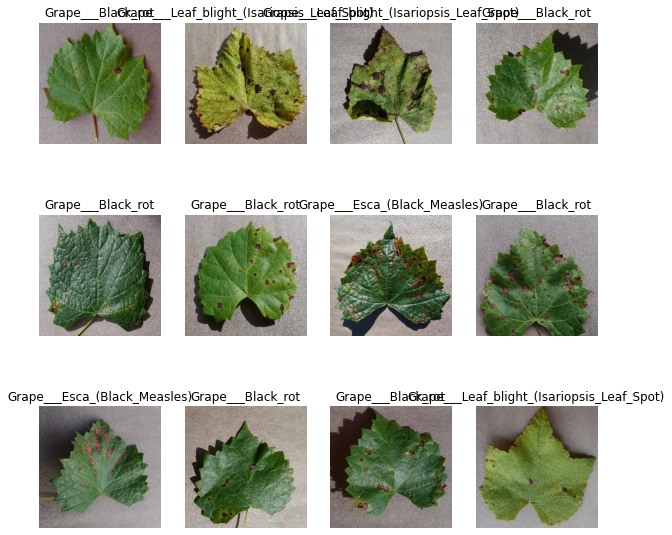

In [117]:
plt.figure(figsize=(10,10))
for image_batch,labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis('off')

In [118]:
train_size = 0.8
len(dataset)*train_size

101.60000000000001

In [119]:
train_ds = dataset.take(101)
len(train_ds)

101

In [120]:
test_ds = dataset.skip(101)
len(test_ds)

26

In [121]:
val_size=0.1
len(dataset)*val_size

12.700000000000001

In [122]:
val_ds = test_ds.take(12)
len(val_ds)

12

In [123]:
test_ds = test_ds.skip(12)
len(test_ds)

14

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [17]:
for image_batch,labels_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[156. 152. 153.]
  [142. 138. 139.]
  [146. 142. 143.]
  ...
  [109.  98.  96.]
  [106.  95.  93.]
  [123. 112. 110.]]

 [[143. 139. 140.]
  [135. 131. 132.]
  [134. 130. 131.]
  ...
  [102.  91.  89.]
  [134. 123. 121.]
  [166. 155. 153.]]

 [[150. 146. 147.]
  [157. 153. 154.]
  [157. 153. 154.]
  ...
  [118. 107. 105.]
  [ 79.  68.  66.]
  [104.  93.  91.]]

 ...

 [[195. 192. 187.]
  [200. 197. 192.]
  [191. 188. 183.]
  ...
  [150. 139. 133.]
  [140. 129. 123.]
  [150. 139. 133.]]

 [[181. 178. 173.]
  [186. 183. 178.]
  [178. 175. 170.]
  ...
  [136. 125. 119.]
  [141. 130. 124.]
  [157. 146. 140.]]

 [[213. 210. 205.]
  [196. 193. 188.]
  [192. 189. 184.]
  ...
  [143. 132. 126.]
  [138. 127. 121.]
  [146. 135. 129.]]]


In [18]:
resize_and_rescale = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
])

In [19]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [21]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    #layers.Conv2D(64, (3, 3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    #layers.Conv2D(64, (3, 3), activation='relu'),
   #layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 30, 30, 64)         

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=15,
)

Epoch 1/15
101/101 [==============================] - 242s 2s/step - loss: 0.7541 - accuracy: 0.6511 - val_loss: 0.3066 - val_accuracy: 0.8880
Epoch 2/15
101/101 [==============================] - 196s 2s/step - loss: 0.2901 - accuracy: 0.8954 - val_loss: 0.1295 - val_accuracy: 0.9479
Epoch 3/15
101/101 [==============================] - 192s 2s/step - loss: 0.1528 - accuracy: 0.9427 - val_loss: 0.0770 - val_accuracy: 0.9688
Epoch 4/15
101/101 [==============================] - 207s 2s/step - loss: 0.0910 - accuracy: 0.9616 - val_loss: 0.1004 - val_accuracy: 0.9714
Epoch 5/15
101/101 [==============================] - 204s 2s/step - loss: 0.0733 - accuracy: 0.9740 - val_loss: 0.0444 - val_accuracy: 0.9870
Epoch 6/15
101/101 [==============================] - 196s 2s/step - loss: 0.0361 - accuracy: 0.9882 - val_loss: 0.0393 - val_accuracy: 0.9844
Epoch 7/15
101/101 [==============================] - 198s 2s/step - loss: 0.0313 - accuracy: 0.9910 - val_loss: 0.0250 - val_accuracy: 0.9844

In [25]:
scores = model.evaluate(test_ds)

14/14 [==============================] - 6s 402ms/step - loss: 0.0024 - accuracy: 0.9978


In [26]:
scores

[0.0023578174877911806, 0.9977678656578064]

In [27]:
history

In [28]:
history.params

{'verbose': 1, 'epochs': 15, 'steps': 101}

In [29]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

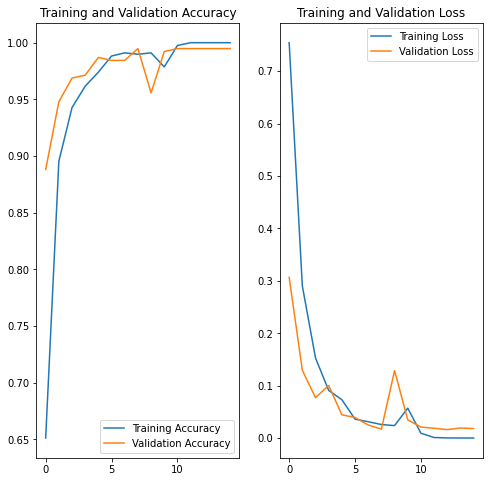

In [31]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS),acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Grape___Esca_(Black_Measles)
predicted label: Grape___Esca_(Black_Measles)


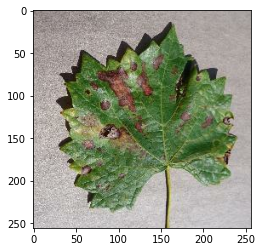

In [32]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [33]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

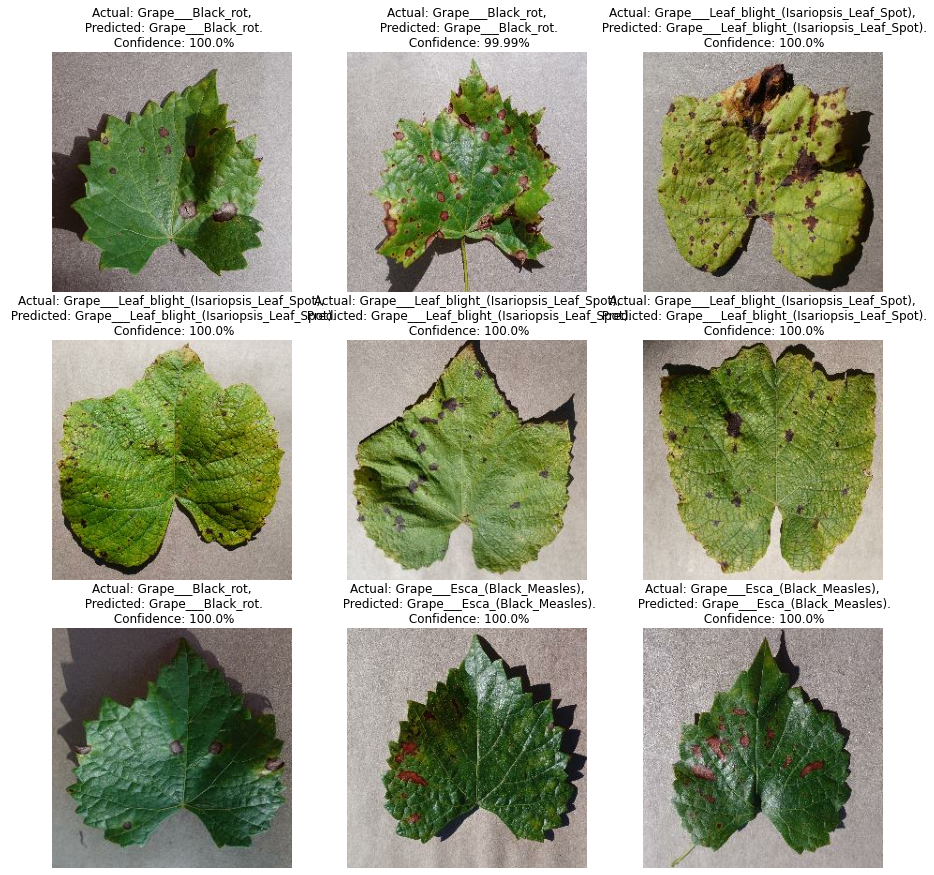

In [34]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [37]:
import os

In [41]:
os.listdir("Grape")

['Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___healthy',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)']

In [48]:
model_version=max([int(i) for i in os.listdir(r"C:/Users/tejas/PycharmProjects/GrapesDisease/grapes_model")+[0]])+1
model.save(r"C:/Users/tejas/PycharmProjects/GrapesDisease/grapes_model/{model_versions}")

INFO:tensorflow:Assets written to: C:/Users/tejas/PycharmProjects/GrapesDisease/grapes_model/{model_versions}\assets


In [52]:
model.save("C:/Users/tejas/PycharmProjects/GrapesDisease/grapes_model/{model_versions}/assets/grape_mod1.h5")

In [58]:
from tensorflow import keras

In [101]:
gm=keras.models.load_model("grape_mod1.h5")

In [102]:
from PIL import Image

In [104]:
img2=Image.open('0ce12a10-c6ff-494e-a927-5ddc809c707a___Mt-Copy1.N.V_HL 8945.JPG')
img2=np.array(img2)
img2


array([[[157, 145, 147],
        [160, 148, 150],
        [161, 149, 151],
        ...,
        [174, 163, 167],
        [171, 160, 164],
        [169, 158, 162]],

       [[152, 140, 142],
        [157, 145, 147],
        [159, 147, 149],
        ...,
        [174, 163, 167],
        [172, 161, 165],
        [170, 159, 163]],

       [[151, 139, 141],
        [155, 143, 145],
        [158, 146, 148],
        ...,
        [173, 162, 166],
        [172, 161, 165],
        [171, 160, 164]],

       ...,

       [[ 76,  71,  77],
        [ 73,  68,  74],
        [ 72,  67,  73],
        ...,
        [163, 160, 167],
        [166, 163, 170],
        [153, 150, 157]],

       [[ 76,  71,  77],
        [ 74,  69,  75],
        [ 73,  68,  74],
        ...,
        [164, 161, 168],
        [159, 156, 163],
        [163, 160, 167]],

       [[ 69,  64,  70],
        [ 67,  62,  68],
        [ 68,  63,  69],
        ...,
        [143, 140, 147],
        [155, 152, 159],
        [165, 162, 169]]

In [105]:
img2=img2.reshape(1,256,256,3)

In [126]:
pred1=gm.predict(img2)
pred1

array([[2.3384875e-07, 4.5467822e-12, 3.5371348e-05, 9.9996436e-01]],
      dtype=float32)

In [125]:
class_names[np.argmax(pred1)]

'Grape___Black_rot'